# 1. Albumentations 

* https://github.com/albumentations-team/albumentations
* 이미지를 쉽게 증가(augmentation) 해주는 파이썬 라이브러리
* 다양한 영상변환 알고리즘을 제공하고 있고, 처리속도도 매우 빨라 딥러닝 전처리 용으로 많이 사용됨
* 모델에 학습시킬 데이터를 증폭시키는 데 사용할 수 있다.

In [ ]:
# !pip install albumentations

In [1]:
import albumentations

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [3]:
import albumentations as A

# Albumentation class 생성하기
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평 전환
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8, # 최대 8개의 구멍을 dropout 시킴
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # callback 함수: 클래스의 객체를 생성한 이후 객체를 호출할 떄 자동으로 실행되는 함수
        if self.transform:
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image'] # 증폭된 이미지
            return img 

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold] 
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8') # 정수로 형변환
                image = self.transform(image=image)
            
            image = image.astype('float32') # 실수로 다시 형변환         
            image = image / 255.
        
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y

In [5]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

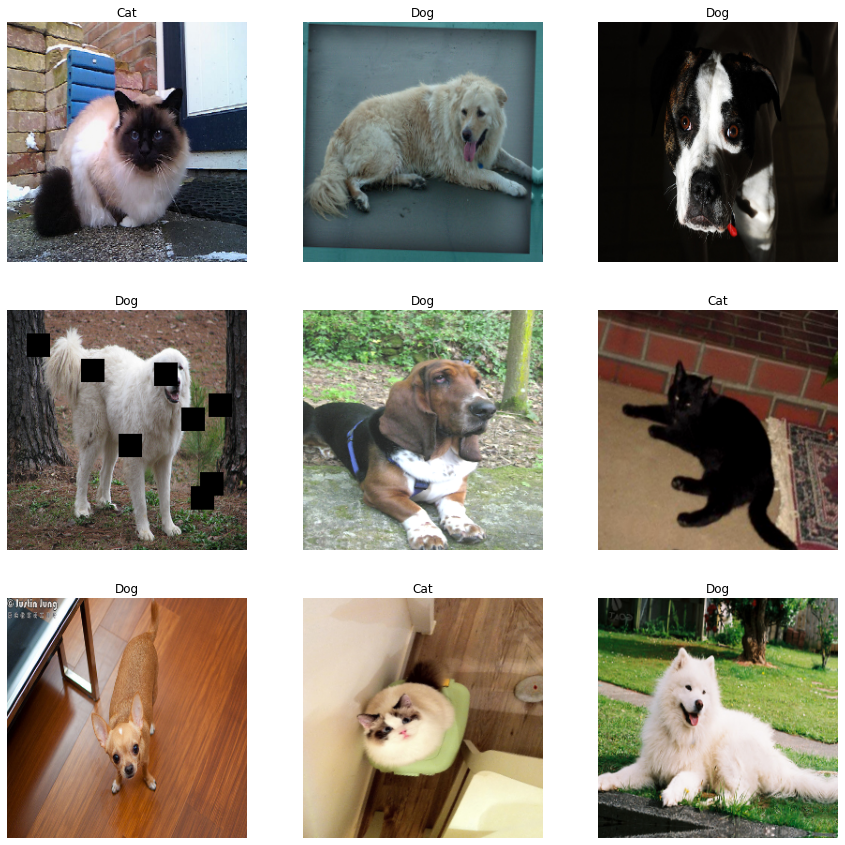

In [6]:
class_name = ['Cat','Dog']

for batch in train_generator:
    X , y = batch
    plt.figure(figsize = (15,15)) # 사진 크기 조정
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    break

In [7]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # input
            layers.Input(input_shape),
            
            # 1번쨰 layer
            layers.Conv2D(64,3,strides = 1,activation = "relu",padding = 'same'), # 이미지를 위한 레이어
            layers.Conv2D(64,3,strides = 1,activation = "relu",padding = 'same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # 2번쨰 layer
            layers.Conv2D(128,3,strides = 1,activation = "relu",padding = 'same'),
            layers.Conv2D(128,3,strides = 1,activation = "relu",padding = 'same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            # Classifier
            layers.GlobalMaxPool2D(),
            layers.Dense(128,activation = "relu"),
            layers.Dense(1,activation = "sigmoid")
        ]
    )
    return model

In [8]:
input_shape = (256,256,3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

model.summary() # 모델의 성능 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     7

In [9]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
46/46 [==============================] - 973s 21s/step - loss: 0.8513 - accuracy: 0.6393 - val_loss: 0.6224 - val_accuracy: 0.6780
Epoch 2/10
46/46 [==============================] - 970s 21s/step - loss: 0.6339 - accuracy: 0.6706 - val_loss: 0.6282 - val_accuracy: 0.6780
Epoch 3/10
46/46 [==============================] - 970s 21s/step - loss: 0.6249 - accuracy: 0.6711 - val_loss: 0.6459 - val_accuracy: 0.6780
Epoch 4/10
46/46 [==============================] - 971s 21s/step - loss: 0.6300 - accuracy: 0.6648 - val_loss: 0.6556 - val_accuracy: 0.6780
Epoch 5/10
46/46 [==============================] - 973s 21s/step - loss: 0.6241 - accuracy: 0.6668 - val_loss: 0.6717 - val_accuracy: 0.6780
Epoch 6/10
46/46 [==============================] - 971s 21s/step - loss: 0.6186 - accuracy: 0.6675 - val_loss: 0.6593 - val_accuracy: 0.6780
Epoch 7/10
46/46 [==============================] - 969s 21s/step - loss: 0.6195 - accuracy: 0.6590 - val_loss: 0.6582 - val_accuracy: 0.6773
Epoch 